# Camera Stuff

![](https://www.photographer.org/wp-content/uploads/2018/06/apeture-f-stop-chart.jpg)

![](https://cdn-7.nikon-cdn.com/Images/Learn-Explore/Photography-Techniques/2009/Focal-Length/Media/red-barn-sequence.jpg)

In [31]:
from math import pi, log10, sqrt
from matplotlib import pyplot as plt
import numpy as np

In [130]:
rad2arcsec = 206265 # [arcsec/rads]

def buildCamera(fpa, f, fnum):
    """
    args:
    - f: focal length [mm]
    - fnum: f-number
    
    return:
    - dia: [cm]
    - pixel: [arcsec]
    - side: pixel size [microns]
    - qe: quantum efficiency [%], turning photons into electrons
    """
    # scale = arcsec2rad/(1000*f)
    # pixel = side*scale
    side = fpa["side"]
    rows = fpa["rows"]
    cols = fpa["cols"]
    pixel = rad2arcsec*side/(1000*f) # pixel size [arcsec]; micron/1000 = mm
    fov = (cols*pixel/3600, rows*pixel/3600) # arcsec
    
    return {
        'dia': 0.1*f/fnum, # appature diameter [cm]
        'rows': rows, # px
        'cols': cols, # px
        'pixel': pixel,  
        'qe': fpa["qe"],    # quantum eff, turning photons into electrons
        'f': f,    # focal length [mm]
        'fnum': fnum,  # f-number
        'fov': fov, # field of view, [width, height] deg
        'readNoise': fpa["readNoise"]
    }

def buildCamera2(fpa, dia, f):
    """
    args:
    - f: focal length [mm]
    - fnum: f-number
    
    return:
    - dia: [cm]
    - pixel: [arcsec]
    - side: pixel size [microns]
    - qe: quantum efficiency [%], turning photons into electrons
    """
    # scale = arcsec2rad/(1000*f)
    # pixel = side*scale
    side = fpa["side"]
    rows = fpa["rows"]
    cols = fpa["cols"]
    pixel = rad2arcsec*side/(1000*f) # pixel size [arcsec]; micron/1000 = mm
    fov = (cols*pixel/3600, rows*pixel/3600) # arcsec
    
    return {
        'dia': dia, # appature diameter [cm]
        'rows': rows, # px
        'cols': cols, # px
        'pixel': pixel,  
        'qe': fpa["qe"],    # quantum eff, turning photons into electrons
        'f': f,    # focal length [mm]
        'fnum': 0.1*f/dia,  # f-number
        'fov': fov, # field of view, [width, height] deg
        'readNoise': fpa["readNoise"]
    }

# focal plane array parameters
fpa = {
    "rows": 6388, # px
    "cols": 9576, # px
    "readNoise": 3.5, # noise [electrons]
    "side": 3.67, # [microns]
    "qe": 0.4
}


# camera parameters
camera = buildCamera(fpa,1800,5)
print(camera)

{'dia': 36.0, 'rows': 6388, 'cols': 9576, 'pixel': 0.4205514166666666, 'qe': 0.4, 'f': 1800, 'fnum': 5, 'fov': (1.1186667683333331, 0.7462451249074074), 'readNoise': 3.5}


In [131]:
def spaceSky(camera, band, mag, sky):
    """
    camera - dictonary of camera parameters
    band - spectrum band in Angstrom
    mag - visual magnitude of interest
    sky - background brightness (mV) of sky
    """
    dia = camera["dia"]
    qe = camera["qe"]
    pixel = camera["pixel"]
    
    v0 = 1000 # flux at mV=0 [photons / (cm^2-Angstrom)]
    area = pi*(dia/2)**2    # area of imager
    fluxv0 = v0*band*qe*area # number photons hitting lense
    fluxmag = 10**(-mag/2.5)*fluxv0
    
    pixsky = sky - 2.5*log10(pixel**2)
    fluxsky = 10**(-pixsky/2.5)*fluxv0
    
    return (fluxv0, fluxmag, fluxsky)

fluxv0, fluxmag, fluxsky = spaceSky(camera, 2500, 21, 22)
print(fluxv0, fluxmag, fluxsky)

1017876019.7630929 4.052237422021402 0.28532057032134905


In [132]:
def performance(cam, integrationTime, fwhm, fluxmag, fluxsky):
    readout = cam["readNoise"]
    imsize = fwhm**2
    signal = fluxmag*integrationTime
    total = signal + imsize*fluxsky*integrationTime
    noise = sqrt(total + imsize*readout**2)
    snr = signal/noise
    pixel = cam["pixel"]
    acc = fwhm*pixel/snr
    # print(imsize,pixel, acc, snr)
    return snr, acc
    
integrationTime = 10 # sec

# full width at half maximum
fwhm = 2 # image diameter pixel

performance(camera, integrationTime, fwhm, fluxmag, fluxsky)

(4.033421094873676, 0.20853335507228413)

In [122]:

integrationTime = 20 # sec

# full width at half maximum
fwhm = 2 # image diameter pixel

dia = []
focalLength = np.arange(1000,1800,10)
fnumber = np.arange(1,4,0.1)
snr = []
for fl in focalLength:
    crow = []
    srow = []
    for fn in fnumber:
        c = buildCamera(fpa,fl,fn)
        fluxv0, fluxmag, fluxsky = spaceSky(c, 2500, 21, 22)
        s, a = performance(c, integrationTime, fwhm, fluxmag, fluxsky)
        crow.append(c["dia"])
        srow.append(s)
    dia.append(crow.copy())
    snr.append(srow.copy())
dia = np.array(dia)
snr = np.array(snr)
X,Y = np.meshgrid(fnumber,focalLength)

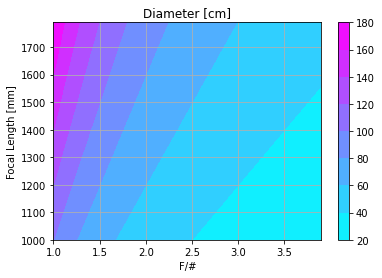

In [123]:
plt.contourf(X,Y,dia, cmap="cool")
plt.colorbar()
plt.xlabel("F/#")
plt.ylabel("Focal Length [mm]")
plt.title("Diameter [cm]")
plt.grid(True);

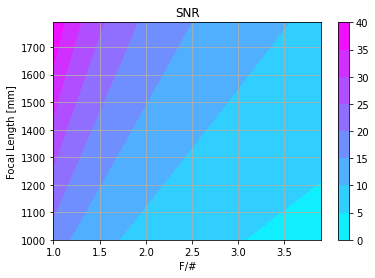

In [124]:
plt.contourf(X,Y,snr, cmap="cool")
plt.colorbar()
plt.xlabel("F/#")
plt.ylabel("Focal Length [mm]")
plt.title("SNR")
plt.grid(True);

In [147]:
integrationTime = 20 # sec

# full width at half maximum
fwhm = 2 # image diameter pixel

dia = 20
focal = 1000

magV = []
snr = []
its = np.arange(1,30)
mags = np.arange(17,21.5,.1)
dia = 20

for integrationTime in its:
    srow = []
    # vrow = []
    for mV in mags:
        c = buildCamera2(fpa,dia,focal)
        fluxv0, fluxmag, fluxsky = spaceSky(c, 2500, mV, 22)
        s, a = performance(c, integrationTime, fwhm, fluxmag, fluxsky)
        srow.append(s)
        # vrow.append(mV)
    # magV.append(irow.copy())
    snr.append(srow.copy())
# magV = np.array(magV)
snr = np.array(snr)
X,Y = np.meshgrid(mags,its)

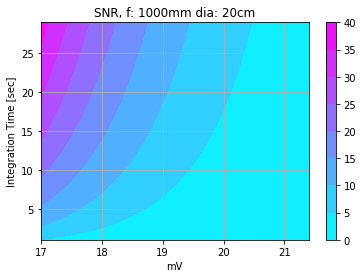

In [148]:
plt.contourf(X,Y,snr, cmap="cool")
plt.colorbar()
plt.xlabel("mV")
plt.ylabel("Integration Time [sec]")
plt.title(f"SNR, f: {focal}mm dia: {dia}cm")
plt.grid(True);